In [14]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth

import os
import pandas as pd
import numpy as np
from pathlib import Path
import time
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor

import ipywidgets as widgets
from savify import Savify
from savify.types import Type, Format, Quality
from savify.utils import PathHolder
import logging

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

from tqdm import tqdm
from IPython.display import display
import plotly.graph_objects as go
import plotly.subplots

# from InstructorEmbedding import INSTRUCTOR
# model = INSTRUCTOR('hkunlp/instructor-large')
# instruction = "Represent the list of genres according to their spectral properties."

%matplotlib inline

# get the client id and client secret from the text file
with open('../spotify_credentials.txt') as f:
    client_id = f.readline().strip().split(' ')[1]
    client_secret = f.readline().strip().split(' ')[1]
    uri = f.readline().split(' ')[1][:-1]
    username = f.readline().split(' ')[1][:-1]


# set the environment variables
os.environ['SPOTIPY_CLIENT_ID'], os.environ['SPOTIFY_CLIENT_ID'] = client_id, client_id
os.environ['SPOTIPY_CLIENT_SECRET'], os.environ['SPOTIFY_CLIENT_SECRET'] = client_secret, client_secret
os.environ['SPOTIPY_REDIRECT_URI'], os.environ['SPOTIFY_REDIRECT_URI'] = uri, uri


auth_manager = SpotifyClientCredentials()
sp = spotipy.Spotify(auth_manager=auth_manager)

# just add all the scopes
scopes = ['user-library-read',
            'user-read-recently-played',
            'user-top-read',
            'user-follow-read',
            'user-read-playback-position',
            'user-read-playback-state',
            'user-read-currently-playing',
            'user-modify-playback-state',
            'user-read-private',
            'playlist-read-private',
            'playlist-read-collaborative',
            'playlist-modify-public',
            'playlist-modify-private']

token = spotipy.util.prompt_for_user_token(username, scopes)

if token:
    sp = spotipy.Spotify(auth=token)
    saved_tracks_resp = sp.current_user_saved_tracks(limit=50)
else:
    print('Couldn\'t get token for that username')

user = sp.user(username)
sp.user = user

In [3]:
# get the features of the current playback
def cur_audio_features():
    return sp.audio_features(sp.current_playback()['item']['id'])

def audio_analysis():
    return sp.audio_analysis(sp.current_playback()['item']['id'])

def cur_playback_info():
    # return dict of name, artist, spotify url and audio features of current playback
    cur_playback = sp.current_playback()
    cur_playback_features = cur_audio_features()
    return {'name': cur_playback['item']['name'],
            'artist': cur_playback['item']['artists'][0]['name'],
            'url': cur_playback['item']['external_urls']['spotify'],
            'features': cur_playback_features}

In [5]:
# set the volume
def set_volume(volume):
    sp.volume(volume)
set_volume(30)

In [11]:
# get the active device
def get_active_device():
    return sp.devices()['devices']
get_active_device()

[{'id': 'b1a5d7096e2a9c1339b49f029db792e7f6c0aa4b',
  'is_active': True,
  'is_private_session': False,
  'is_restricted': False,
  'name': 'C02D91JSML86',
  'supports_volume': True,
  'type': 'Computer',
  'volume_percent': 50},
 {'id': '38ff607c4538f8f97eb2907563fa32ada8c1274f',
  'is_active': False,
  'is_private_session': False,
  'is_restricted': False,
  'name': 'Chromecast HD',
  'supports_volume': True,
  'type': 'TV',
  'volume_percent': 0},
 {'id': 'd047ce3ab6351a19649ca1538b07039810aaf33e',
  'is_active': False,
  'is_private_session': False,
  'is_restricted': False,
  'name': 'Pixel 7',
  'supports_volume': False,
  'type': 'Smartphone',
  'volume_percent': 100}]

In [5]:
analysis = audio_analysis()
for i in analysis['sections']:
    print(i['duration'])

8.68517
13.7774
42.41208
12.75693
46.89131
14.14367
19.66112
11.37685
21.71789
25.1487
6.21332


In [6]:
for i in analysis['sections']:
    print(i.keys())

dict_keys(['start', 'duration', 'confidence', 'loudness', 'tempo', 'tempo_confidence', 'key', 'key_confidence', 'mode', 'mode_confidence', 'time_signature', 'time_signature_confidence'])
dict_keys(['start', 'duration', 'confidence', 'loudness', 'tempo', 'tempo_confidence', 'key', 'key_confidence', 'mode', 'mode_confidence', 'time_signature', 'time_signature_confidence'])
dict_keys(['start', 'duration', 'confidence', 'loudness', 'tempo', 'tempo_confidence', 'key', 'key_confidence', 'mode', 'mode_confidence', 'time_signature', 'time_signature_confidence'])
dict_keys(['start', 'duration', 'confidence', 'loudness', 'tempo', 'tempo_confidence', 'key', 'key_confidence', 'mode', 'mode_confidence', 'time_signature', 'time_signature_confidence'])
dict_keys(['start', 'duration', 'confidence', 'loudness', 'tempo', 'tempo_confidence', 'key', 'key_confidence', 'mode', 'mode_confidence', 'time_signature', 'time_signature_confidence'])
dict_keys(['start', 'duration', 'confidence', 'loudness', 'tempo'

In [7]:
def get_current_time():
    start = time.time()
    t = sp.current_playback()['progress_ms']
    end = time.time()
    latency = end - start
    return (t + latency)/1000

In [8]:
cur_song_analysis = audio_analysis()
sections = cur_song_analysis['sections']
sections = dict(zip(range(len(sections)), sections))
cur_time = get_current_time()
# find the current section based on the current time
for i, section in enumerate(list(sections.values())):
    if section['start'] < cur_time < section['start'] + section['duration']:
        cur_section = i
        break
start = time.time()
# get current section from time

prev_section = cur_section-1
while True:
    # find the current section based on the current time
    for i, section in enumerate(list(sections.values())):
        if section['start'] < cur_time < section['start'] + section['duration']:
            cur_section = i
            break
    # check if the section has changed
    if cur_section != prev_section:
        # change the color of the section
        # change the color of the previous section
        prev_section = cur_section
        print(f"New section: section{cur_section}")
        # print out all the section info
        print(sections[cur_section])
    cur_time = get_current_time()

### Something to try is to look at the segment timbre vectors within the sections in order to classify each section

New section: section8
{'start': 169.70453, 'duration': 21.71789, 'confidence': 0.744, 'loudness': -3.316, 'tempo': 174.026, 'tempo_confidence': 0.811, 'key': 9, 'key_confidence': 0.415, 'mode': 1, 'mode_confidence': 0.176, 'time_signature': 4, 'time_signature_confidence': 1.0}


KeyboardInterrupt: 

In [9]:
all_playlists = sp.current_user_playlists()

In [10]:
# find the ice rave playlist
for playlist in all_playlists['items']:
    if playlist['name'] == 'ICE RAVE':
        ice = playlist
        break

In [11]:
def get_playlist_df(playlist_id):
    results = sp.playlist_tracks(playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])

    # convert this into a dataframe with the audio features, song name, artist, id, and link
    features = []
    for track in tracks:
        feature_data = sp.audio_features(track['track']['id'])[0]
        feature_data['name'] = track['track']['name']
        feature_data['artist'] = track['track']['artists'][0]['name']
        feature_data['id'] = track['track']['id']
        feature_data['link'] = track['track']['external_urls']['spotify']
        feature_data['popularity'] = track['track']['popularity']
        # get genres as a string
        genres = []
        for artist in track['track']['artists']:
            genres.extend(sp.artist(artist['id'])['genres'])
        # collapse genres into a single string, with each genre separated by a comma
        feature_data['genres'] = ', '.join(genres)
        features.append(feature_data)



    out = pd.DataFrame(features)
    # drop "type" and "uri" columns
    out.drop(columns=['type', 'uri'], inplace=True)
    return out


ice_df = get_playlist_df(ice['id'])
ice_df.to_csv('ice_rave.csv', index=False)

In [12]:
ice_df.head()

danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.744   0.614    1    -3.908     0       0.0838      0.006850   
1         0.762   0.766    7    -3.955     1       0.0343      0.007760   
2         0.802   0.756    2   -10.791     0       0.0349      0.084300   
3         0.530   0.770    9    -5.882     1       0.0824      0.000965   
4         0.677   0.766    6    -6.896     1       0.0568      0.021900   

   instrumentalness  liveness  valence  ...                      id  \
0          0.334000    0.0708    0.774  ...  2idmlkd8oUaQvYEtINpLBX   
1          0.000070    0.1280    0.442  ...  5fwSHlTEWpluwOM0Sxnh5k   
2          0.007650    0.0521    0.963  ...  6ztstiyZL6FXzh4aG46ZPD   
3          0.011500    0.2650    0.107  ...  00Ci0EXS4fNPnkTbS6wkOh   
4          0.000007    0.1290    0.198  ...  51Of5p3lKZeOg6itfs4og4   

                                          track_href  \
0  https://api.spotify.com/v1/tracks/2idmlkd8oUaQ...   
1  https://api.spotify.com/v1/tracks/5fwSHlTEWplu...   
2  https://api.spotify.com/v1/tracks/6ztstiyZL6FX...   
3  https://api.spotify.com/v1/tracks/00Ci0EXS4fNP...   
4  https://api.spotify.com/v1/tracks/51Of5p3lKZeO...   

                                        analysis_url duration_ms  \
0  https://api.spotify.com/v1/audio-analysis/2idm...      383547   
1  https://api.spotify.com/v1/audio-analysis/5fwS...      287120   
2  https://api.spotify.com/v1/audio-analysis/6zts...      288293   
3  https://api.spotify.com/v1/audio-analysis/00Ci...      253880   
4  https://api.spotify.com/v1/audio-analysis/51Of...      190488   

   time_signature                            name              artist  \
0               4  Heads Will Roll - A-Trak Remix     Yeah Yeah Yeahs   
1               4                           Pepas             Farruko   
2               4               Boogie Wonderland  Earth, Wind & Fire   
3               3    Electric Love - Oliver Remix               BØRNS   
4               4                        Lovefool           twocolors   

                                                link popularity  \
0  https://open.spotify.com/track/2idmlkd8oUaQvYE...         64   
1  https://open.spotify.com/track/5fwSHlTEWpluwOM...         83   
2  https://open.spotify.com/track/6ztstiyZL6FXzh4...         79   
3  https://open.spotify.com/track/00Ci0EXS4fNPnkT...         57   
4  https://open.spotify.com/track/51Of5p3lKZeOg6i...         73   

                                              genres  
0  alternative dance, alternative rock, art pop, ...  
1              reggaeton, trap latino, urbano latino  
2  disco, funk, jazz funk, soul, chicago soul, cl...  
3  indie poptimism, modern alternative rock, mode...  
4                            edm, pop dance, pop edm  

[5 rows x 21 columns]

In [14]:
# download the songs to the downloads folder and put the path as a column in the dataframe
s = Savify(path_holder=path_holder, logger=logger, download_format=Format.MP3)
def download_songs(df):
    df['path'] = ''
    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        artist = row['artist']
        song = row['name']
        url = row['link']
        # download the song
        s.download(url)
        filepath = Path('downloads/IceRave') / f'{artist} - {song}.mp3'
        print(filepath)
        df.loc[i, 'path'] = filepath

    return df

# download the songs
ice_tracks = download_songs(ice_df)

  1%|          | 1/174 [00:00<00:54,  3.19it/s]

downloads/IceRave/Yeah Yeah Yeahs - Heads Will Roll - A-Trak Remix.mp3


ERROR: Unable to extract uploader id; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.
ERROR: Unable to extract uploader id; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.
  1%|          | 1/174 [00:04<13:07,  4.55s/it]


KeyboardInterrupt: 

ERROR: Unable to extract uploader id; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.
ERROR: Unable to extract uploader id; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.
ERROR: Unable to extract uploader id; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.
ERROR: Unable to extract uploader id; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call 

In [ ]:
# new_tracks = pd.DataFrame(columns=elm_tracks.columns)
# new_tracks.to_csv('new_tracks.csv', index=False)

In [ ]:
while True:
    time.sleep(3)
    # check if playing
    if not sp.current_playback():
        print('Not playing')
        continue
    elif sp.current_playback()['item']['id'] != current_song_id:
        print(sp.current_playback()['item']['name'])
        current_song_id = sp.current_playback()['item']['id']
        # find the song in the playlist
        try:
            song = elm_tracks[elm_tracks['id'] == current_song_id]
        except:
            print('Song not found in playlist repository. Getting data and downloading...')
            song = sp.audio_features(current_song_id)
            song['name'] = sp.track(current_song_id)['name']
            song['artist'] = sp.track(current_song_id)['artists'][0]['name']
            song['id'] = current_song_id
            song['link'] = sp.track(current_song_id)['external_urls']['spotify']
            song['popularity'] = sp.track(current_song_id)['popularity']
            song['genres'] = sp.artist(sp.track(current_song_id)['artists'][0]['id'])['genres']
            song = pd.DataFrame(song)
            song = download_songs(song)
            # add to new_tracks
            new_tracks = new_tracks.append(song)

TypeError: list indices must be integers or slices, not str

In [ ]:
feature_list = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'valence']
feature_list_small = ['danceability', 'energy', 'loudness', 'valence', 'tempo', 'popularity']

danceability  energy  loudness  valence    tempo  popularity
0         0.771   0.687    -9.814    0.783  118.392          71
1         0.778   0.719    -9.698    0.729  115.400          70
2         0.705   0.712    -6.156    0.620   97.512          82
3         0.692   0.711    -7.498    0.875  125.135          85
4         0.483   0.579   -13.923    0.891  122.527          54

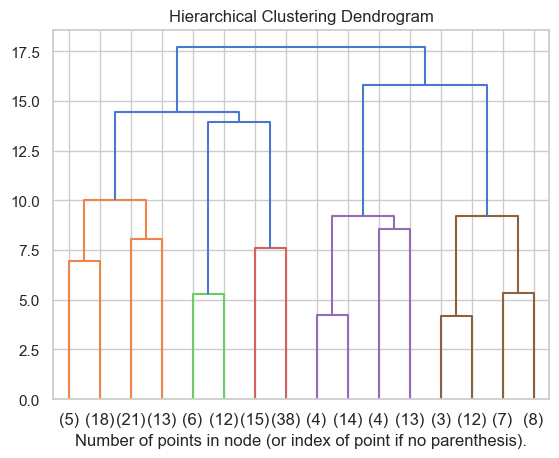

In [ ]:
# do agglomerative clustering on the features and plot the dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# grab audio features of all the songs in the playlist, keep track of names and artists
# then do agglomerative clustering on the features
# then plot the dendrogram
def plot_dendrogram_playlist(playlist_df):
    X = playlist_df[feature_list_small]
    
    display(X.head())
    # setting distance_threshold=0 ensures we compute the full tree.
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

    # scale the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    model = model.fit(X)
    plt.title("Hierarchical Clustering Dendrogram")
    # plot the top three levels of the dendrogram
    plot_dendrogram(model, truncate_mode="level", p=3)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.show()

plot_dendrogram_playlist(elm_tracks)

/Users/f004swn/anaconda3/envs/spotify/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


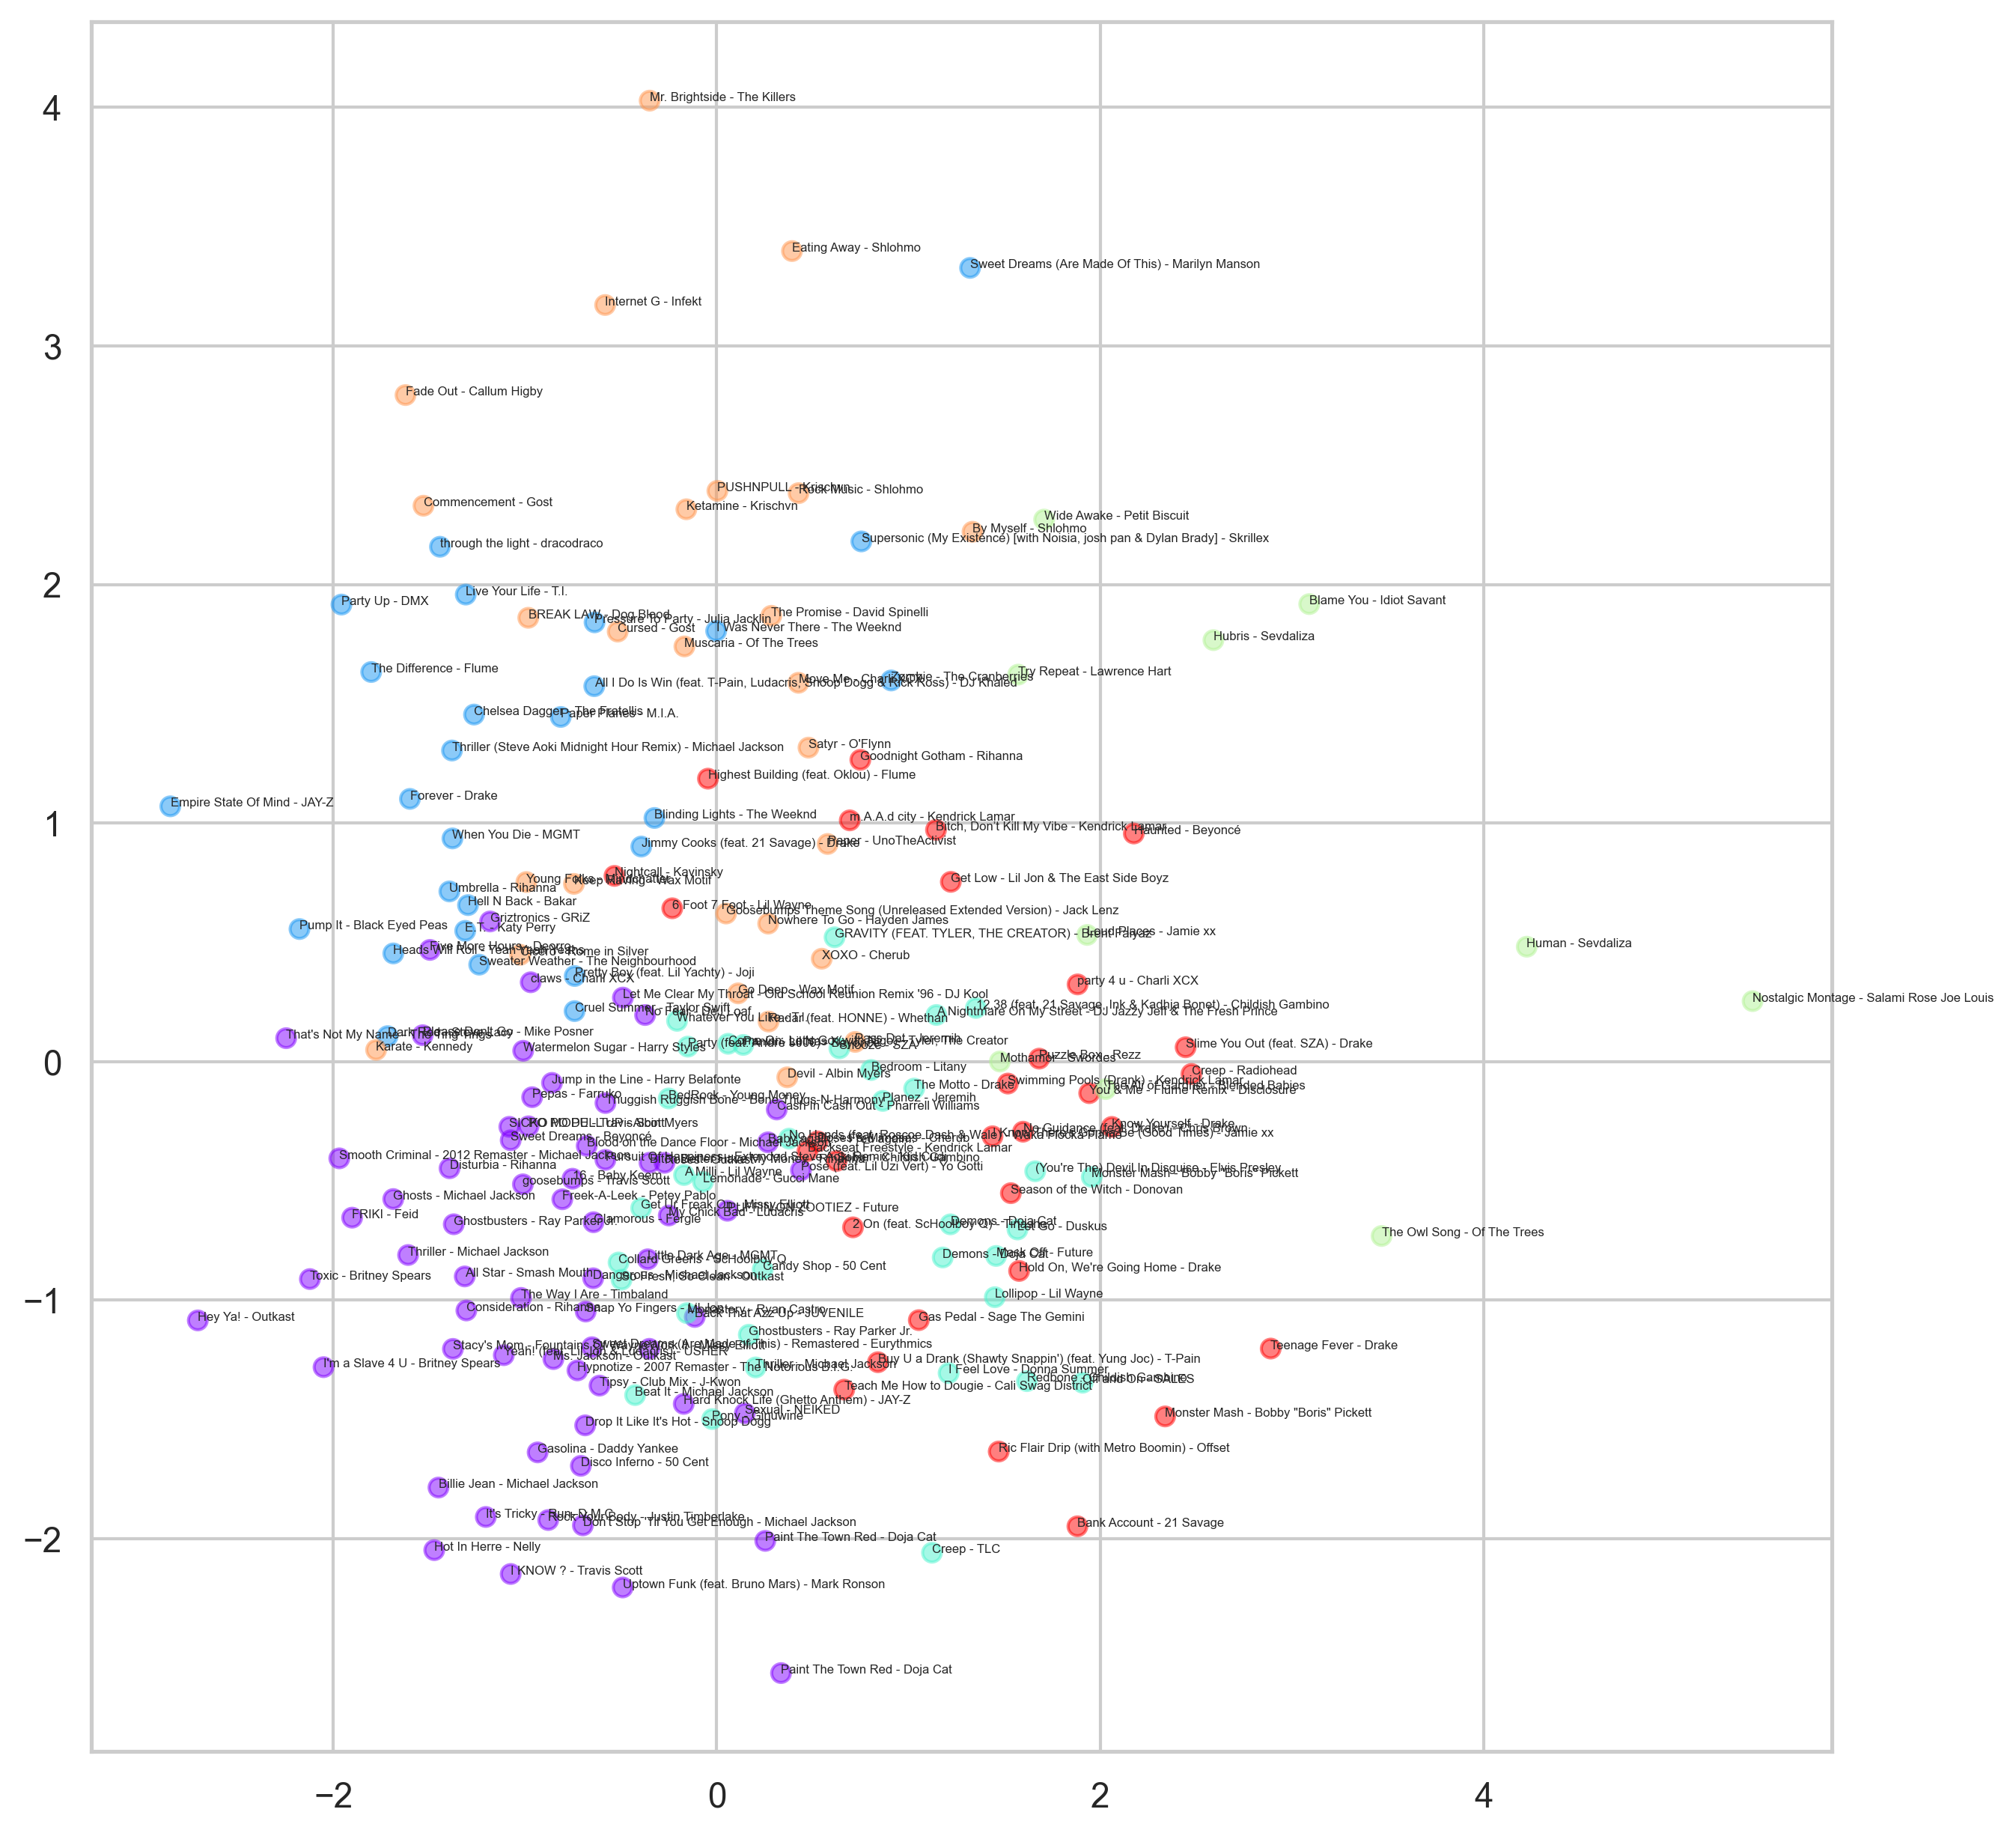

In [ ]:
# do kmeans clustering on the features with n=8 clusters and plot the silhouette score
km = KMeans(n_clusters=6)
scaler = StandardScaler()
X = scaler.fit_transform(elm_tracks[feature_list_small])
km.fit(X)

# plot a lower dimensional representation of the data and color by cluster
# include song labels in the plot
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
songs = elm_tracks['name'] + ' - ' + elm_tracks['artist']

plt.figure(figsize=(10, 10), dpi=300)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=km.labels_, cmap='rainbow', alpha=0.5, label=songs)
# add the song labels
for i, song in enumerate(songs):
    plt.annotate(song, (X_pca[i, 0], X_pca[i, 1]), fontsize=4)

plt.show()


In [ ]:
# find the influential columns from the PCA
# get the eigenvectors
eigenvectors = pca.components_
# get the eigenvalues
eigenvalues = pca.explained_variance_
# get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
# get the cumulative sum of the explained variance ratio
cumulative_sum = np.cumsum(explained_variance_ratio)

print(f'Explained variance ratio: {explained_variance_ratio}')
print(f'Cumulative sum: {cumulative_sum}')
print(f'Total explained variance: {np.sum(explained_variance_ratio)}')


Explained variance ratio: [0.21348554 0.17469421 0.13227337 0.11983802 0.09639247 0.08740265
 0.08387719 0.06809888]
Cumulative sum: [0.21348554 0.38817975 0.52045313 0.64029115 0.73668361 0.82408626
 0.90796345 0.97606233]
Total explained variance: 0.9760623278994869


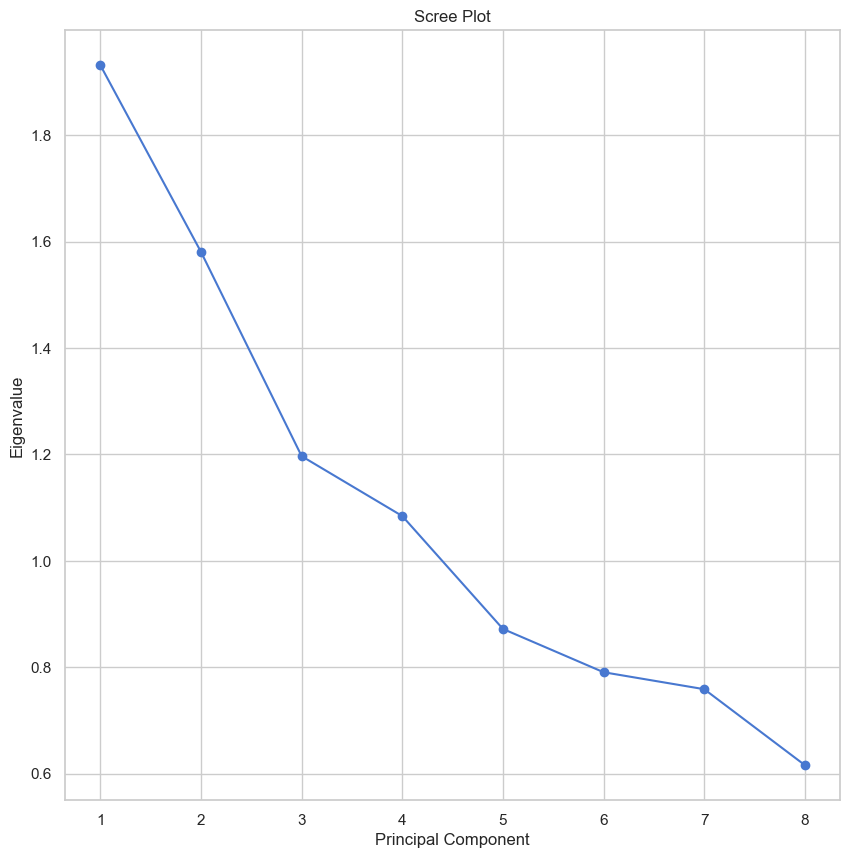

In [ ]:
# do the scree plot
plt.figure(figsize=(10, 10), dpi=100)
plt.plot(np.arange(1, len(eigenvalues)+1), eigenvalues, 'o-')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.show()

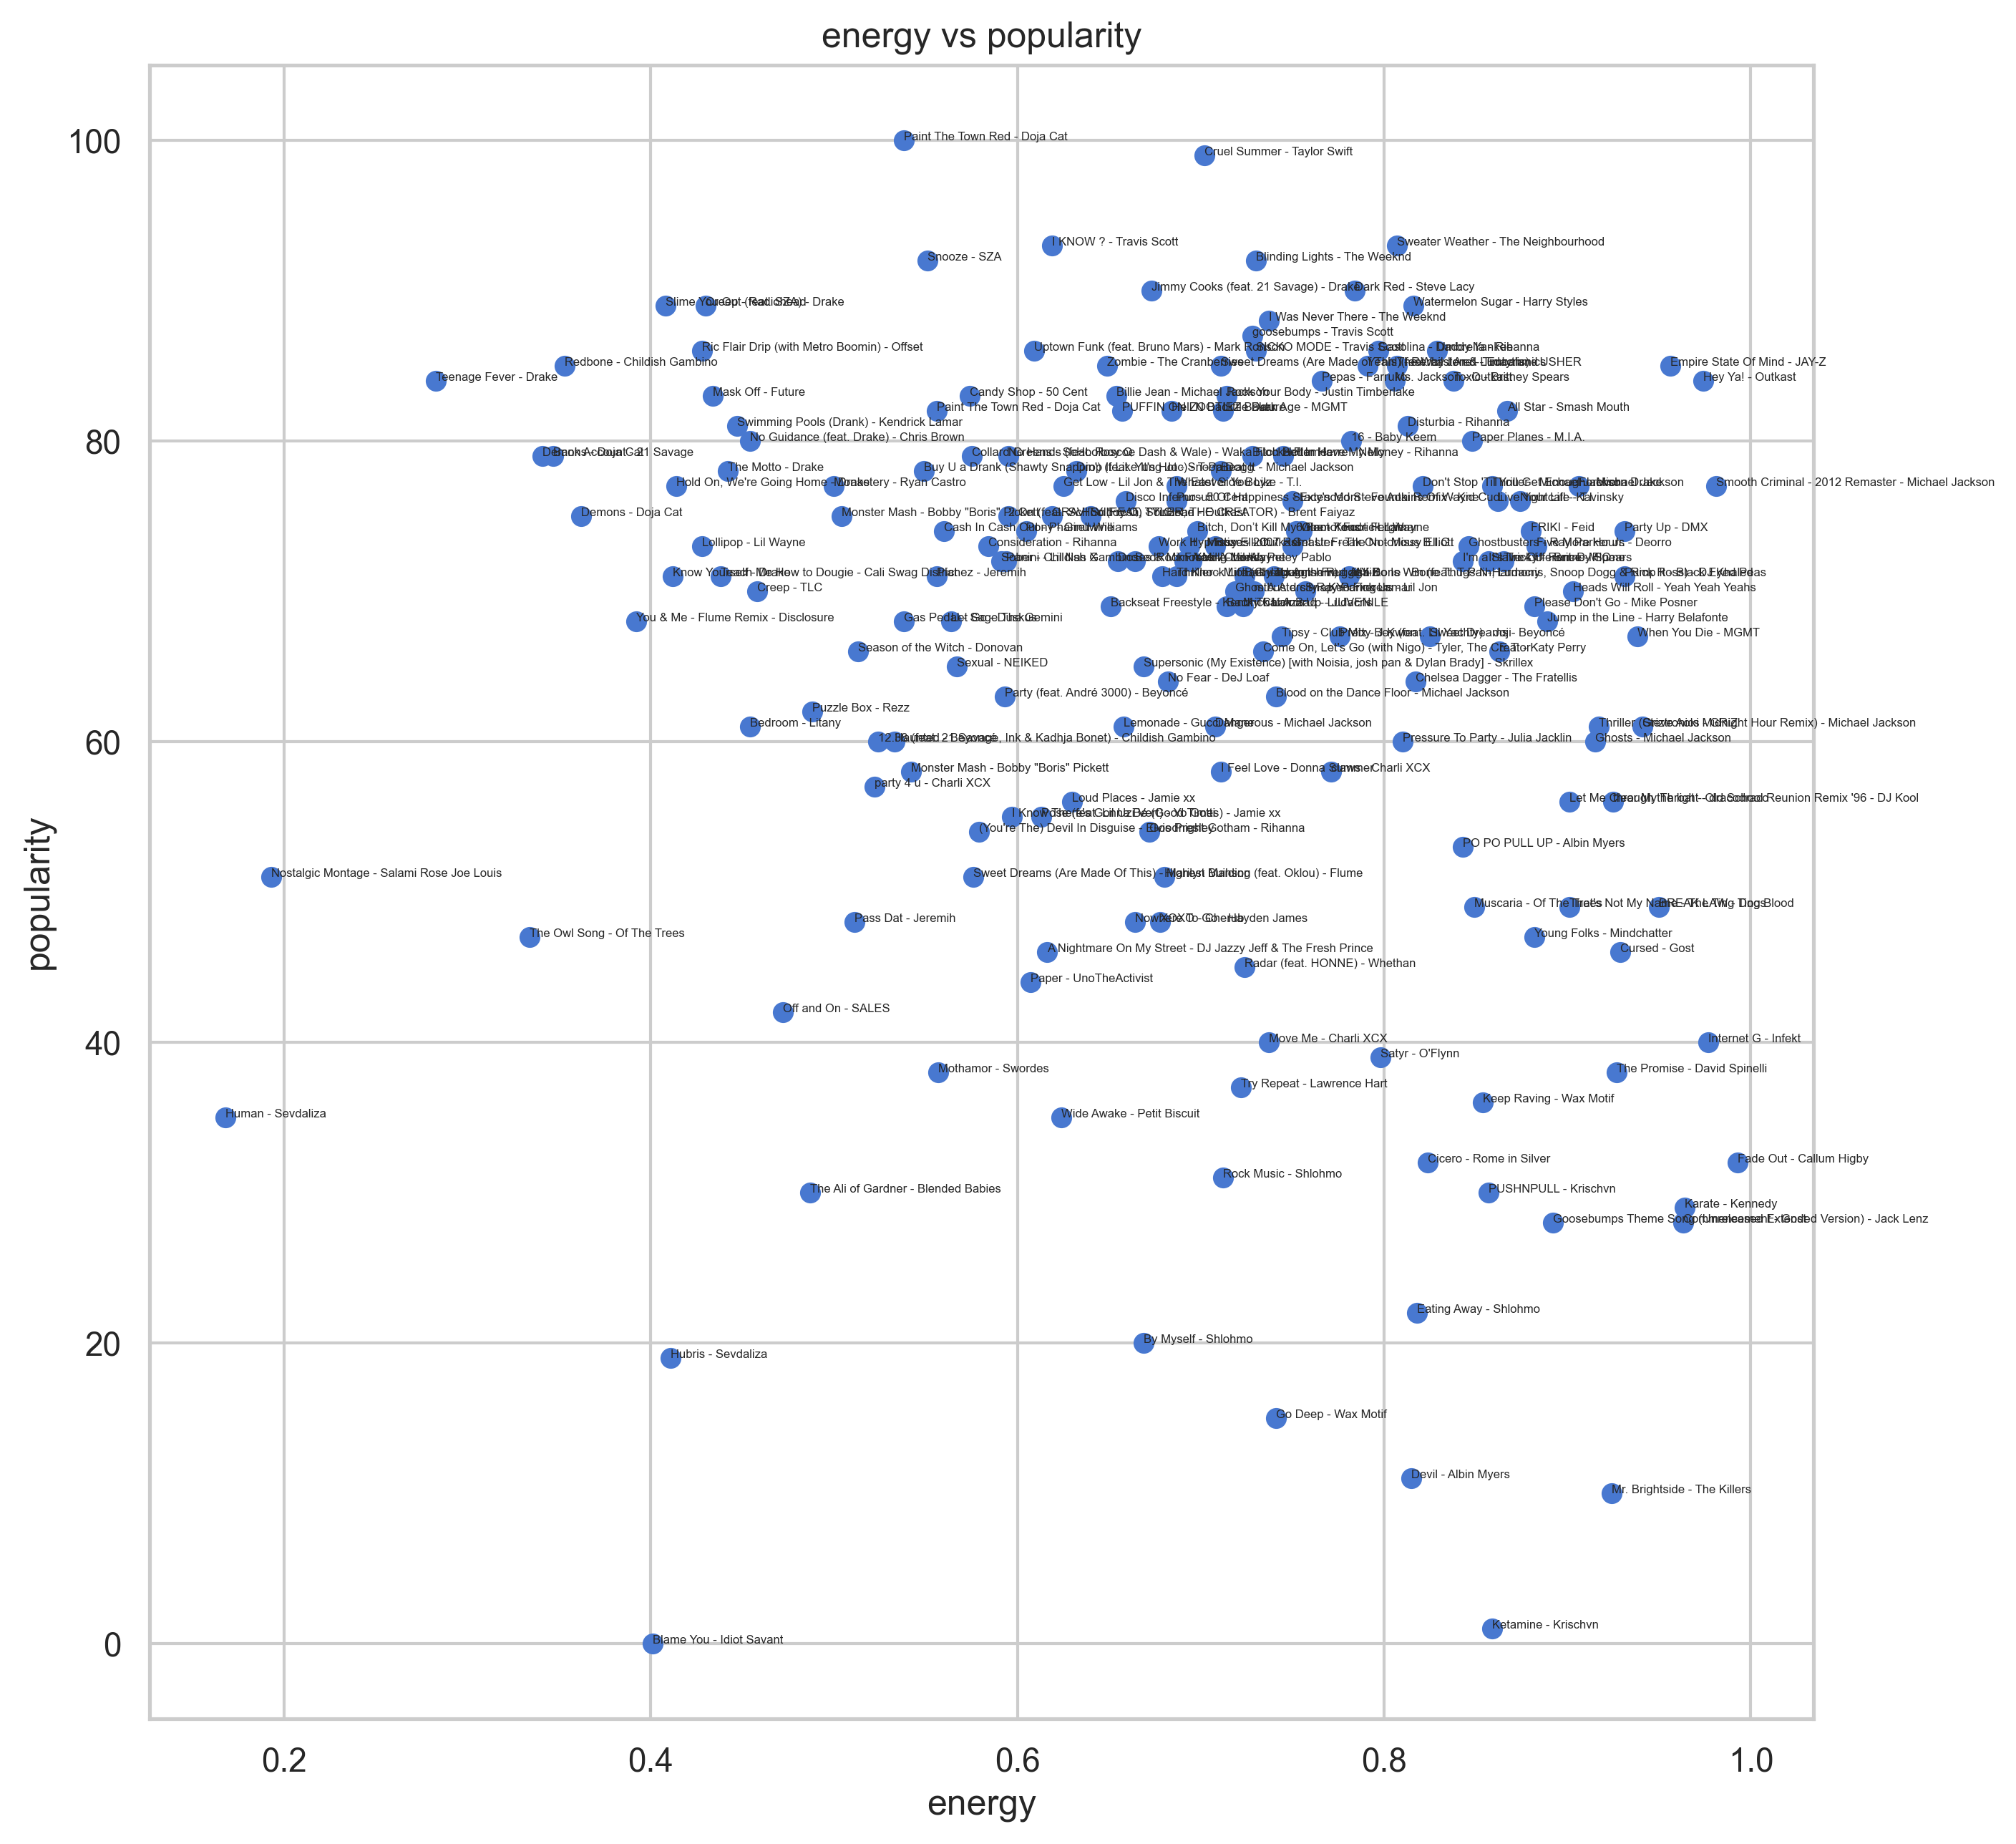

In [ ]:
def show_data(xfeature, yfeature, playlist_df):
    plt.figure(figsize=(10, 10), dpi=300)
    plt.scatter(playlist_df[xfeature], playlist_df[yfeature])
    plt.xlabel(xfeature)
    plt.ylabel(yfeature)
    plt.title(f'{xfeature} vs {yfeature}')
    # add song labels
    for i, song in enumerate(songs):
        plt.annotate(song, (playlist_df[xfeature][i], playlist_df[yfeature][i]), fontsize=4)
    plt.show()

show_data('energy', 'popularity', elm_tracks)

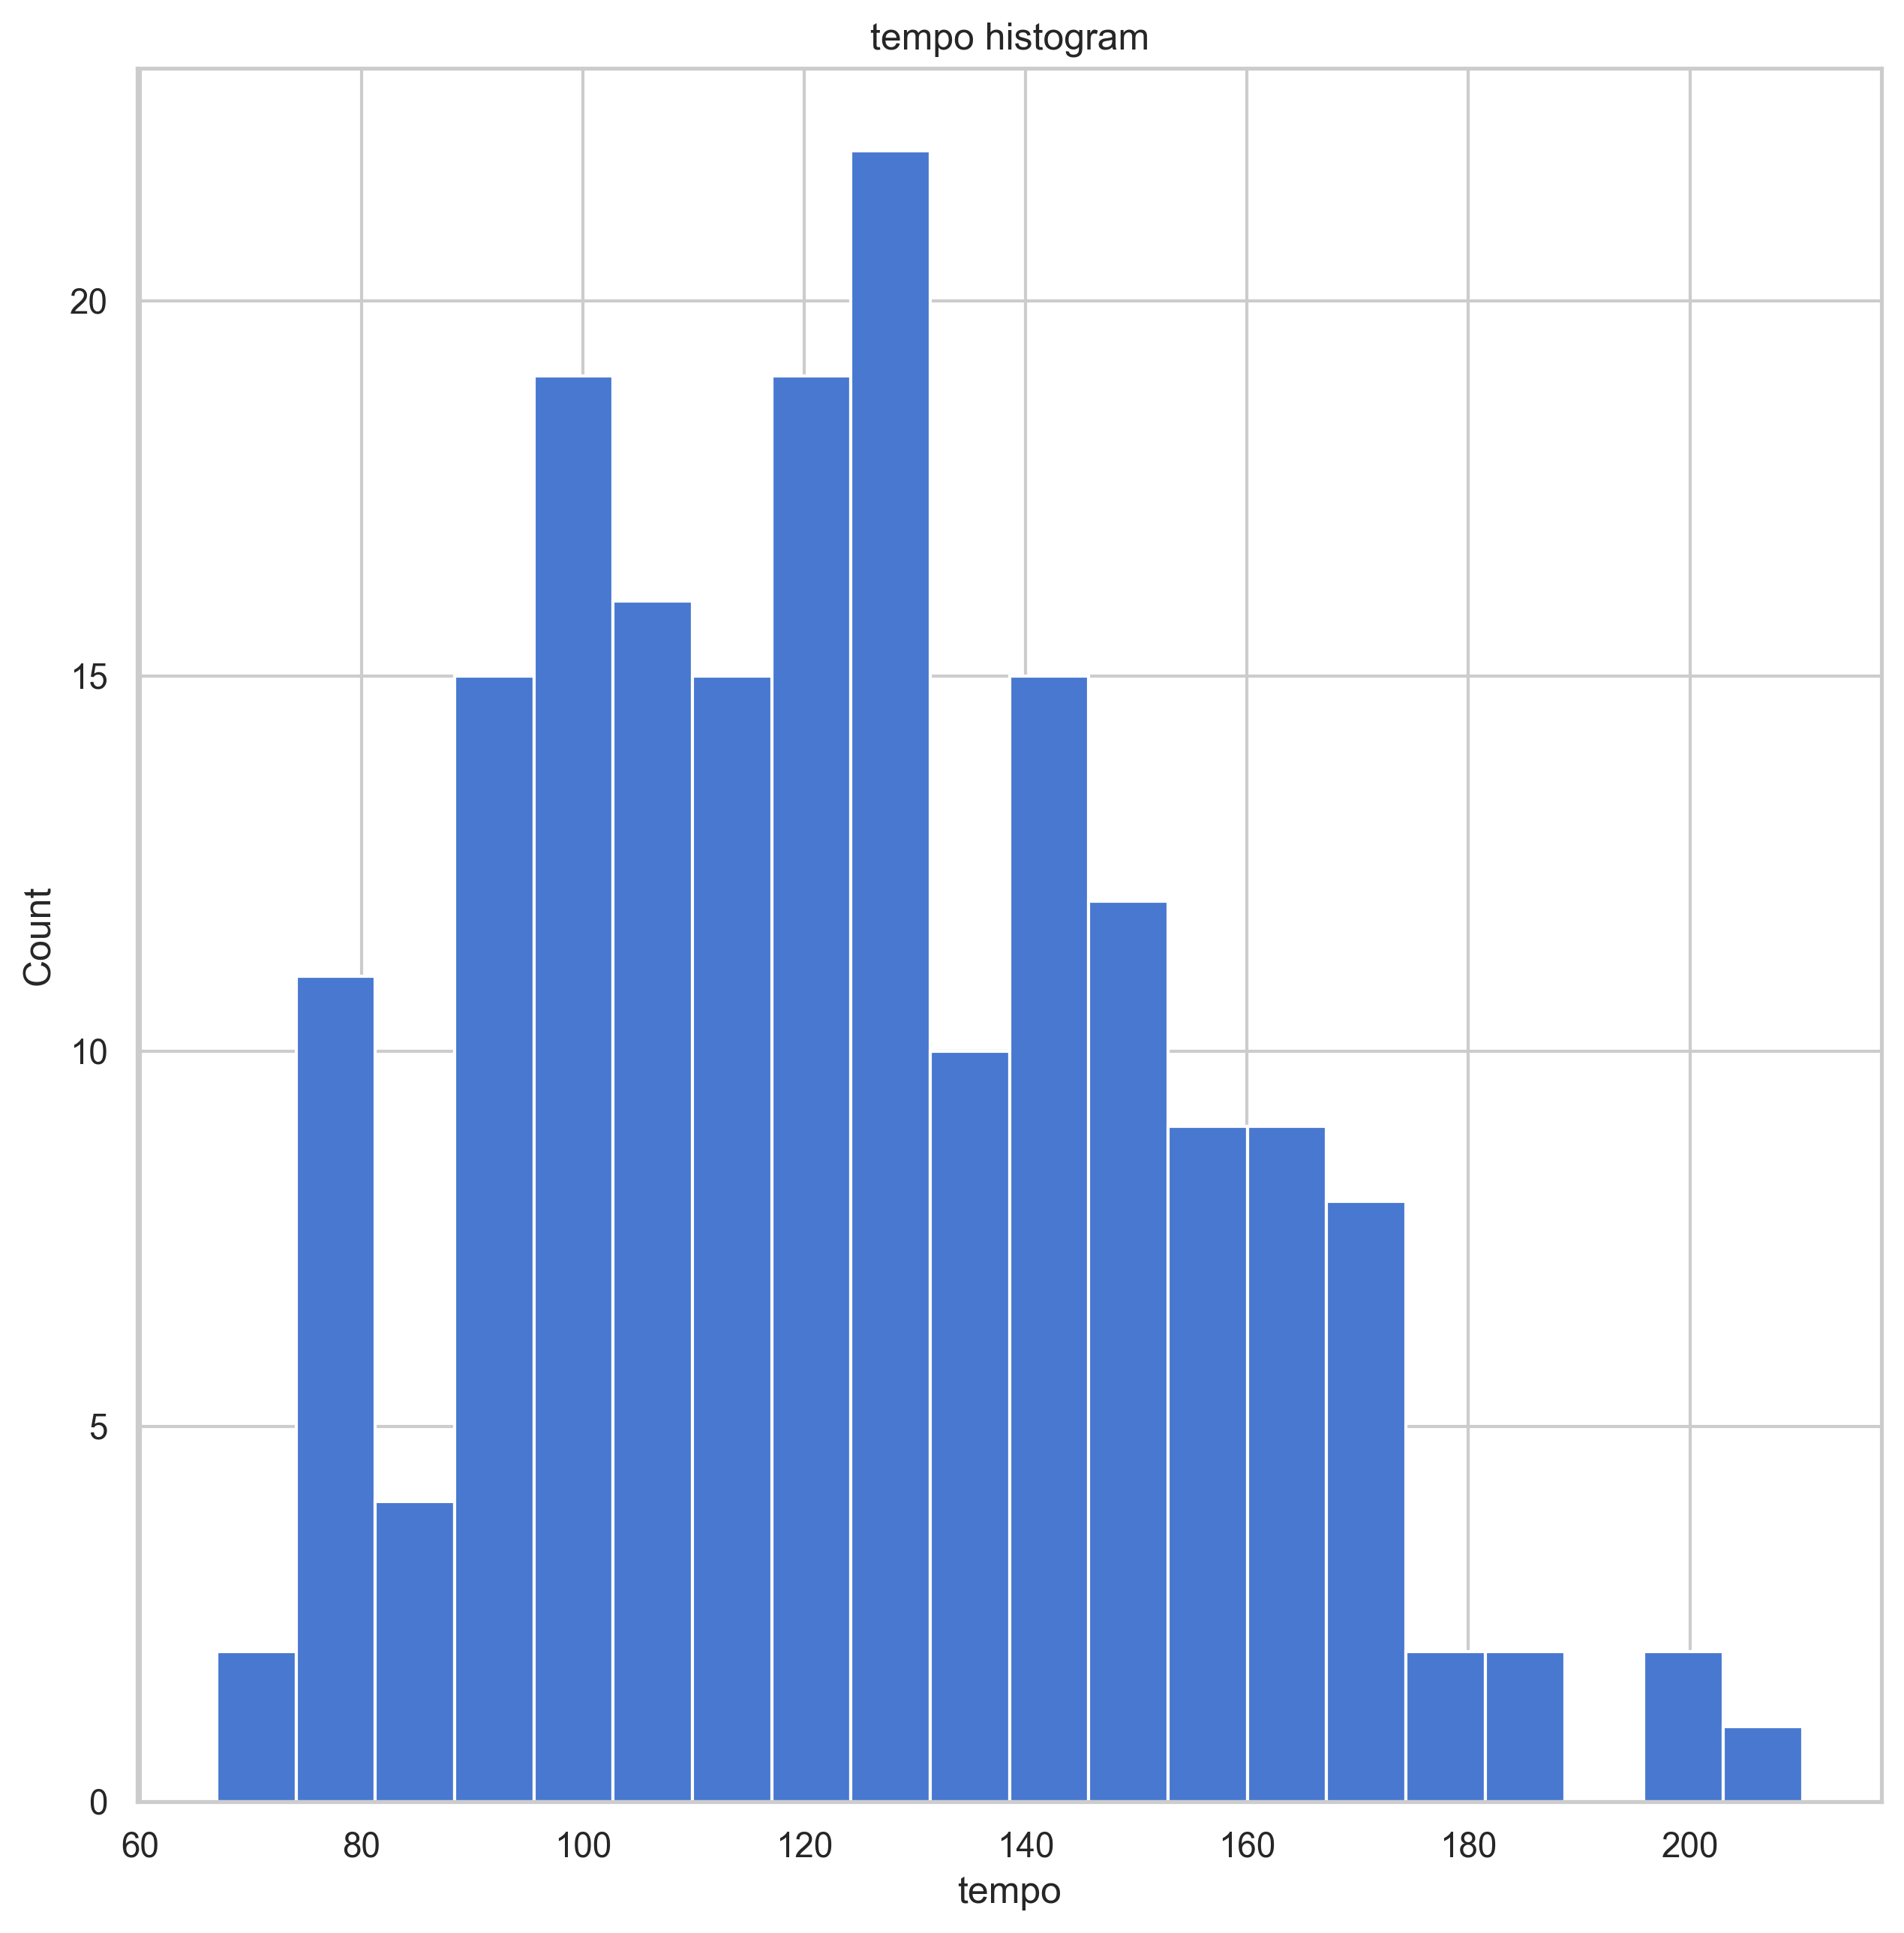

In [ ]:
# function for plotting a histogram of a given featre
def feature_hist(feature, playlist_df):
    plt.figure(figsize=(10, 10), dpi=300)
    plt.hist(playlist_df[feature], bins=20)
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(f'{feature} histogram')
    plt.show()

feature_hist('tempo', elm_tracks)